In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iamprateek","key":"df8c46acc5ffff6edab82517982811c2"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
mohansacharya/graduate-admissions                            Graduate Admissions                                   9KB  2018-12-28 10:07:14           5900  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59           4739  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2018-09-18 20:49:49          33431  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56           1903  
safegraph/visit-patterns-by-census-block-group            

In [5]:
!kaggle competitions download -c elo-merchant-category-recommendation
!ls

 96% 519M/538M [00:07<00:00, 95.2MB/s]
100% 538M/538M [00:07<00:00, 76.5MB/s]
 41% 5.00M/12.2M [00:00<00:00, 51.9MB/s]
100% 12.2M/12.2M [00:00<00:00, 82.8MB/s]
 96% 47.0M/48.9M [00:00<00:00, 48.4MB/s]
100% 48.9M/48.9M [00:00<00:00, 88.9MB/s]
  0% 0.00/838k [00:00<?, ?B/s]
100% 838k/838k [00:00<00:00, 253MB/s]
  0% 0.00/1.09M [00:00<?, ?B/s]
100% 1.09M/1.09M [00:00<00:00, 217MB/s]
  0% 0.00/2.93M [00:00<?, ?B/s]
100% 2.93M/2.93M [00:00<00:00, 287MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 15.1MB/s]
Data_Dictionary.xlsx		   sample_data
historical_transactions.csv.zip    sample_submission.csv.zip
kaggle.json			   test.csv.zip
merchants.csv.zip		   train.csv.zip
new_merchant_transactions.csv.zip


In [6]:
"""

Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. 
But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? 
Personalization is key.

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. 
But so far none of them is specifically tailored for an individual or profile. This is where you come in.

In this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.

"""

'\n\nRight now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. \nBut do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? \nPersonalization is key.\n\nElo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. \nBut so far none of them is specifically tailored for an individual or profile. This is where you come in.\n\nIn this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.\n\n'

In [7]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [0]:
import zipfile

In [0]:
with zipfile.ZipFile("train.csv.zip","r") as z:
  z.extractall()

In [0]:
with zipfile.ZipFile("test.csv.zip","r") as z:
  z.extractall()

In [0]:
with zipfile.ZipFile("sample_submission.csv.zip","r") as z:
  z.extractall()

In [0]:
with zipfile.ZipFile("historical_transactions.csv.zip","r") as z:
  z.extractall()

In [0]:
with zipfile.ZipFile("merchants.csv.zip","r") as z:
  z.extractall()

In [0]:
with zipfile.ZipFile("new_merchant_transactions.csv.zip","r") as z:
  z.extractall()

In [15]:
train_df = pd.read_csv("train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [16]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


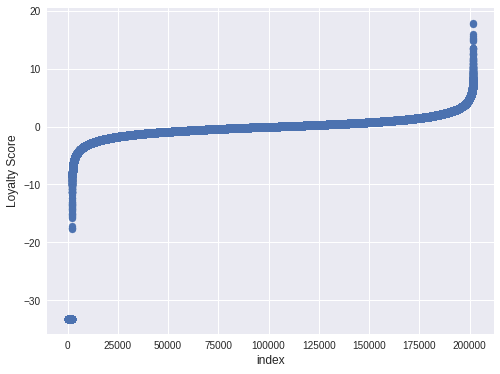

In [17]:
# let us explore the target column
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



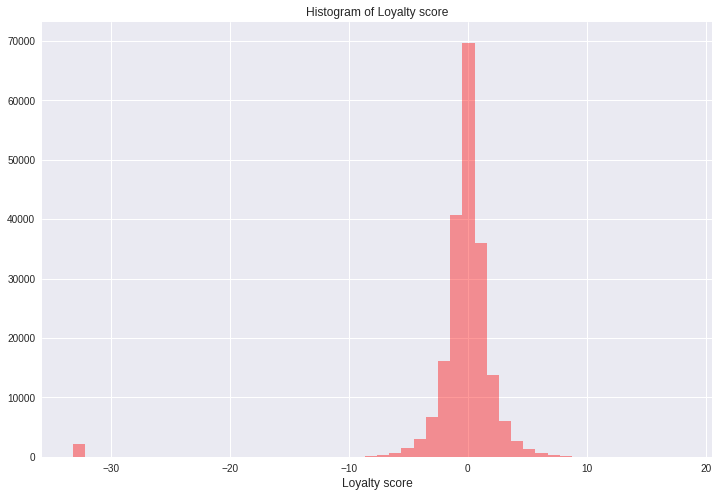

In [18]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [19]:
# We can see that some of the loyalty values are far apart (less than -30) compared to others. Let us just get their count.
(train_df[target_col]<-30).sum()

2207

In [20]:
"""
We have about 2207 rows (almost 1% of the data), which has values different from the rest. 
Since the metric RMSE these rows might play an important role. So beware of them.

"""

'\nWe have about 2207 rows (almost 1% of the data), which has values different from the rest. \nSince the metric RMSE these rows might play an important role. So beware of them.\n\n'

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



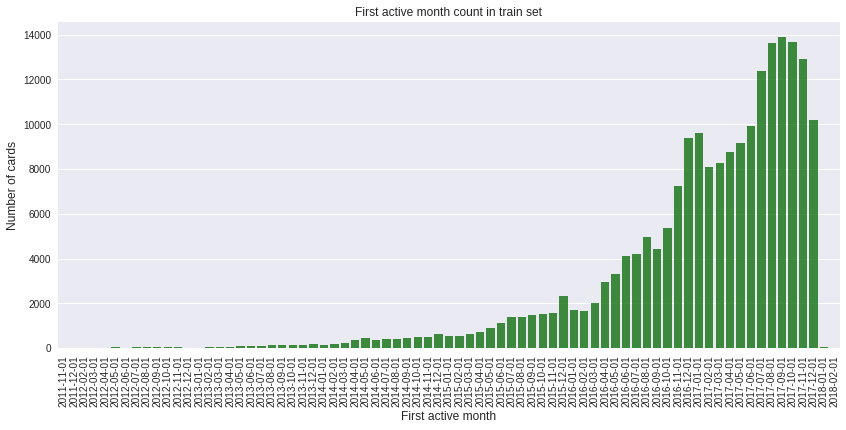

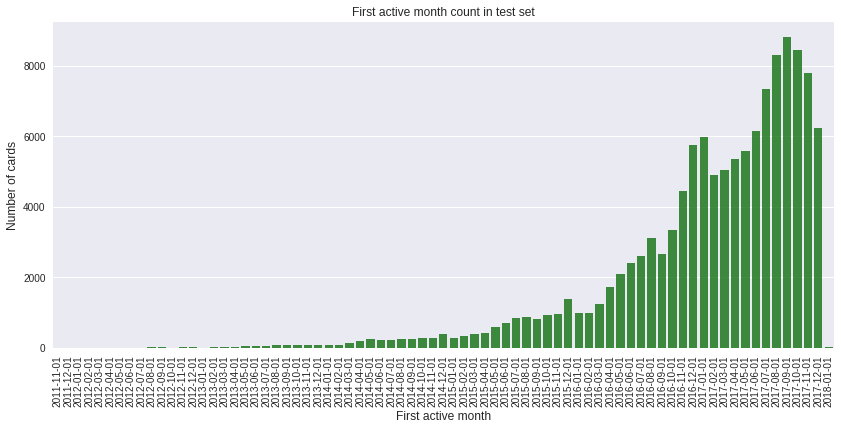

In [21]:
# In this section, let us see if there are any distribution change between train and test sets with respect to first active month of the card.
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

In [22]:
"""
Looks like the distribution is kind of similar between train and test set. So we need not really have to do time based split I think.

"""

'\nLooks like the distribution is kind of similar between train and test set. So we need not really have to do time based split I think.\n\n'

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



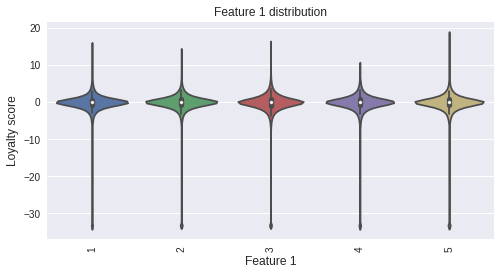

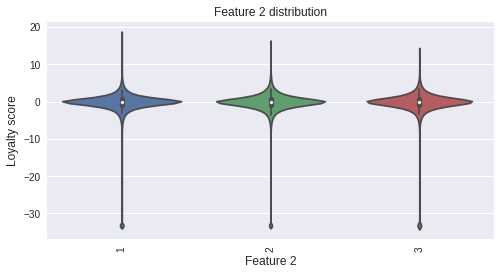

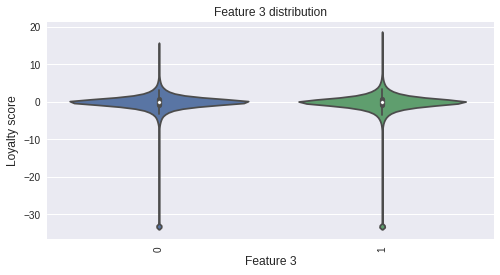

In [23]:
# In this section, let us see if the other variables in the train dataset has good predictive power in finding the loyalty score.
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

In [24]:
"""
To the naked eyes, the distribution of the different categories in all three features look kind of similar. May be the models are able to find something here.

"""

'\nTo the naked eyes, the distribution of the different categories in all three features look kind of similar. May be the models are able to find something here.\n\n'

In [25]:
# Now let us look at the historical transactions data for the cards.
hist_df = pd.read_csv("historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [26]:
# Now let us make some features based on the historical transactions and merge them with train and test set.

# Number of Historical Transactions for the card
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
print(gdf.head())
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")
print(train_df.head())

           card_id  purchase_amount
0  C_ID_00007093c1              149
1  C_ID_0001238066              123
2  C_ID_0001506ef0               66
3  C_ID_0001793786              216
4  C_ID_000183fdda              144
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  num_hist_transactions  
0 -0.820283                    260  
1  0.392913                    350  
2  0.688056                     43  
3  0.142495                     77  
4 -0.159749                    133  


In [27]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout, validation=False)
py.iplot(fig, filename="Histtranscnt")

PlotlyDictValueError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



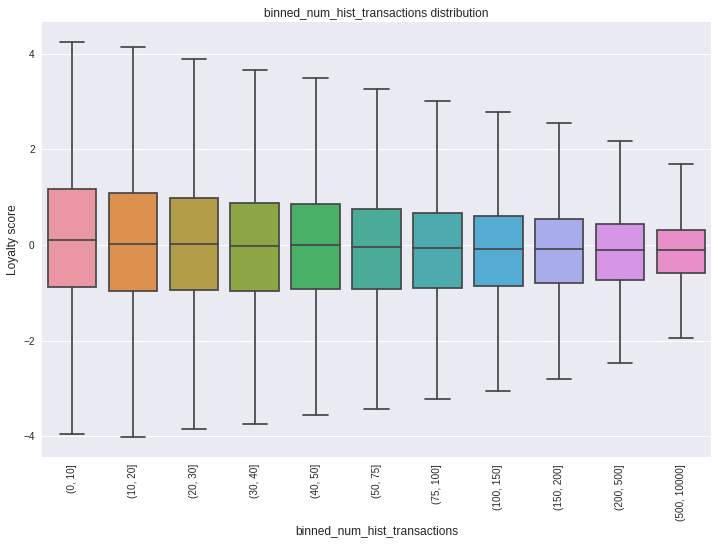

In [28]:
# Now let us bin the count of historical transactions and then do some box plots to see the plots better.
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

In [0]:
# Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



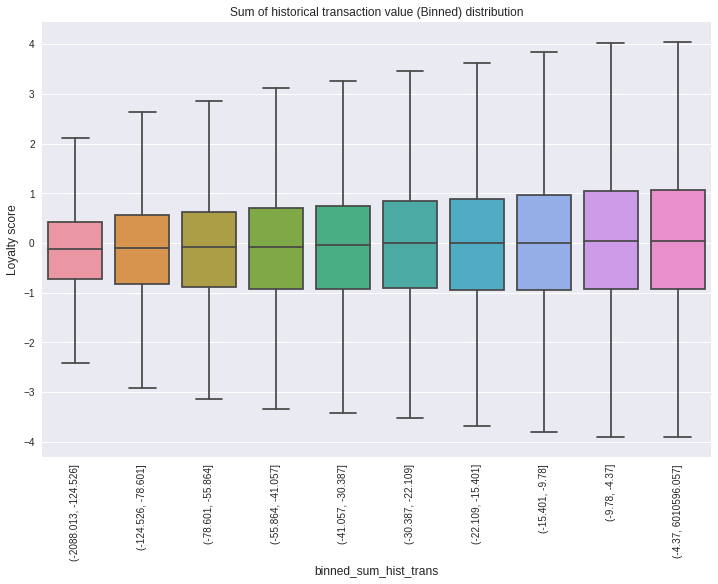

In [30]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

In [31]:
new_trans_df = pd.read_csv("new_merchant_transactions.csv")
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [0]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



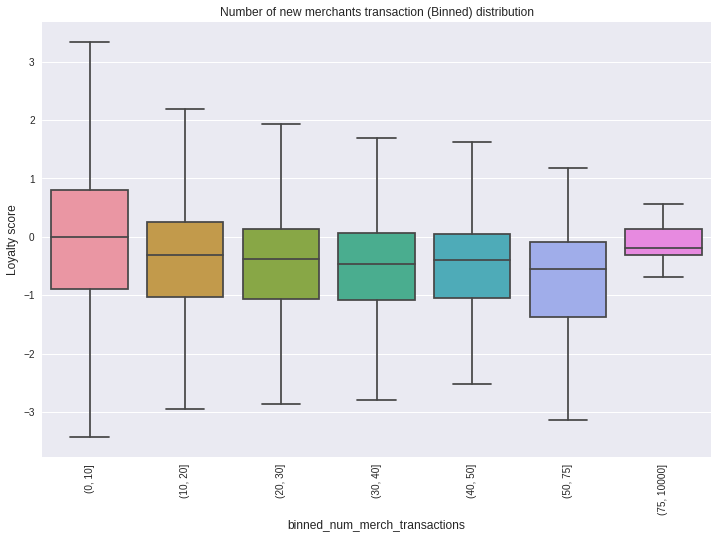

In [35]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

In [0]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



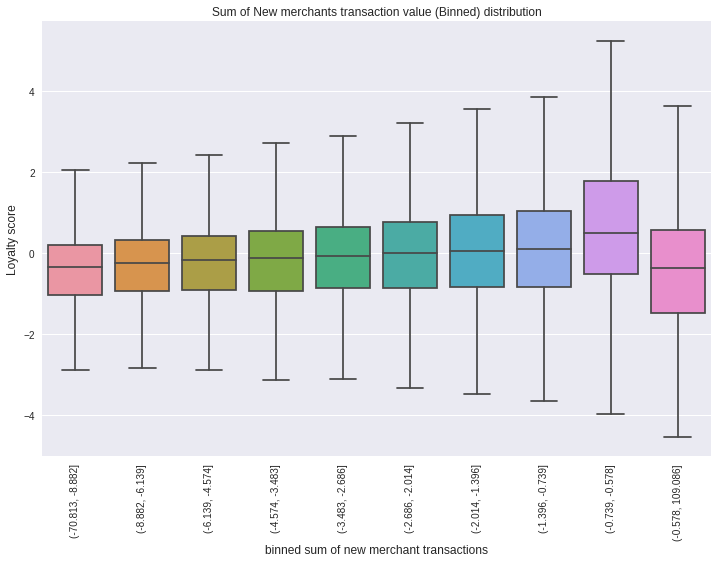

In [37]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



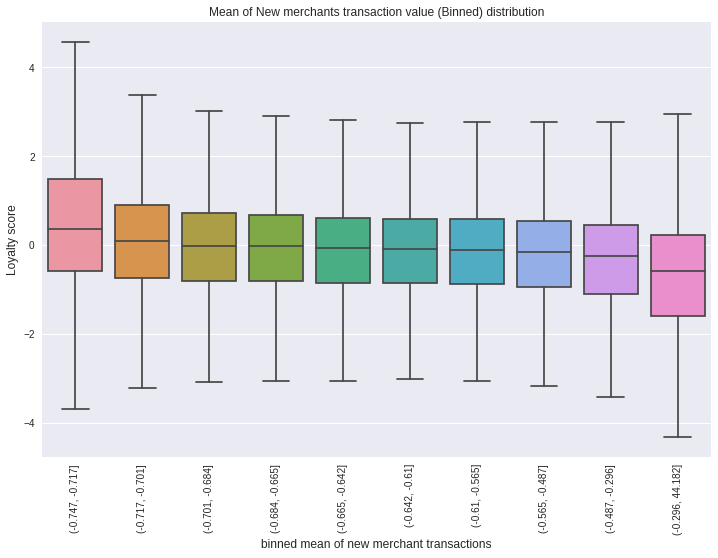

In [38]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

In [0]:
# Let us build a baseline model using the features created so far.
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

In [40]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


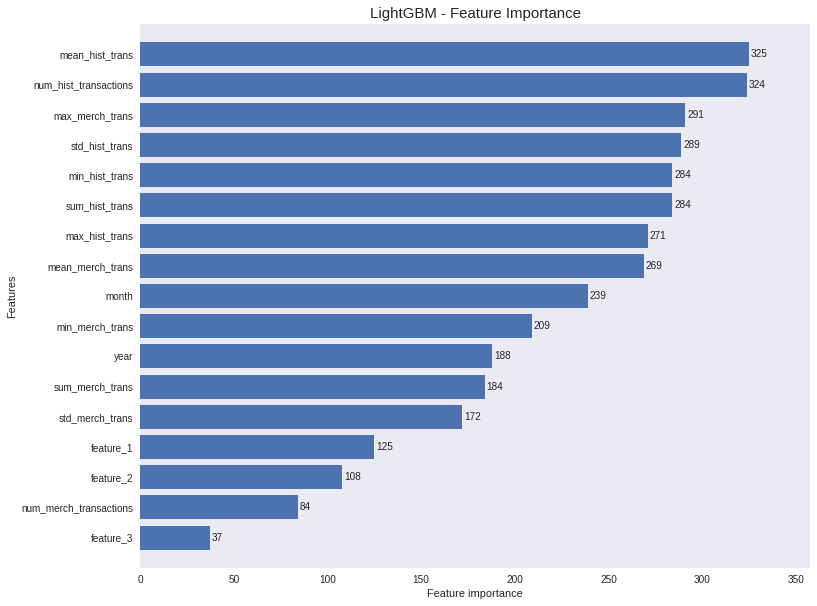

In [41]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [42]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)
my_sub = pd.read_csv("baseline_lgb.csv")
my_sub.head(20)

,card_id,target
0,C_ID_0ab67a22ab,-0.671773
1,C_ID_130fd0cbdd,-0.954398
2,C_ID_b709037bc5,-0.748285
3,C_ID_d27d835a9f,-0.109886
4,C_ID_2b5e3df5c2,-1.147402
5,C_ID_5814b4f13c,0.111656
6,C_ID_a1b3c75277,-0.027284
7,C_ID_f7cada36d3,0.119163
8,C_ID_9d2bc8dfc4,-1.013018
9,C_ID_6d8dba8475,-0.771607
